Exploratory Data Analysis

In [54]:
import pandas as pd

cashrequestdf = pd.read_csv("project_dataset/cashreq.csv")
feesdf = pd.read_csv("project_dataset/fees.csv")

In [55]:
print("first created date is: ",cashrequestdf["created_at"].min())
print("last created date is: ",cashrequestdf["created_at"].max())
print(cashrequestdf.shape)

first created date is:  2019-11-19 13:57:53.511561+00
last created date is:  2020-11-01 23:42:30.847066+00
(23970, 16)


In [56]:
cashrequestdf.describe()

,id,amount,user_id,deleted_account_id
count,23970.000000,23970.000000,21867.000000,2104.000000
mean,13910.966124,82.720818,32581.250789,9658.755228
std,7788.117214,26.528065,27618.565773,7972.743249
min,3.000000,1.000000,34.000000,91.000000
25%,7427.250000,50.000000,10804.000000,3767.000000
50%,14270.500000,100.000000,23773.000000,6121.500000
75%,20607.750000,100.000000,46965.000000,16345.000000
max,27010.000000,200.000000,103719.000000,30445.000000


In [57]:
cashrequestdf.isnull().sum() # 2130 user_id missing

id                                0
amount                            0
status                            0
created_at                        0
updated_at                        0
user_id                        2103
moderated_at                   7935
deleted_account_id            21866
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
transfer_type                     0
send_at                        7329
recovery_status               20640
reco_creation                 20640
reco_last_update              20640
dtype: int64

In [58]:
cashrequestdf.nunique()

id                            23970
amount                           41
status                            7
created_at                    23970
updated_at                    23970
user_id                       10798
moderated_at                  16035
deleted_account_id             1141
reimbursement_date             4089
cash_request_received_date      312
money_back_date               12221
transfer_type                     2
send_at                       16641
recovery_status                   4
reco_creation                  3330
reco_last_update               3330
dtype: int64

In [59]:
feesdf.nunique()
#Vemos que cuando el type es = incident entonces category = month_delay_on_payment o deject_direct_debit.

id                 21061
cash_request_id    12933
type                   3
status                 4
category               2
total_amount           2
reason             15149
created_at         21026
updated_at         21061
paid_at            15529
from_date           1084
to_date             1560
charge_moment          2
dtype: int64

In [60]:
feesdf[feesdf["total_amount"] != 5.0]
#Hemos encontrado un valor de total_amount = 10.0 en un unico caso lo que nos hace suponer que se trata de un error del sistema.

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
20604,15552,22799.0,instant_payment,accepted,NaN,10.0,Instant Payment Cash Request 22799,2020-10-21 13:01:52.493241+00,2021-01-21 15:42:51.372269+00,2020-10-30 00:18:41+00,NaN,NaN,after


#proximos pasos:

1. arreglar columna de user_id
2. agregar el cohort dependiendo de la primer transaccion
3. unir los dataframes  (incident rates esta en la tabla de fees)
4. crear un nuevo dataframe que combine las columnas que queremos (para revenue vamos a tener que calcular total_amount por mes y por usuario)

In [61]:
# updated column names as they have the same column name. Could create problems when merged together.
cashrequestdf = cashrequestdf.rename(columns={"id": "cash_request_id", "status": "cash_request_status", "created_at": "cash_request_created_at", "updated_at": "cash_request_updated_at", "reason": "cash_request_reason"})
feesdf = feesdf.rename(columns={"id": "fee_id", "status": "fee_status", "created_at": "fee_created_at", "updated_at": "fee_updated_at", "reason": "fee_reason"})

In [62]:
# Add boolean flags
cashrequestdf["was_moderated"] = cashrequestdf["moderated_at"].notna()
cashrequestdf["was_deleted_account"] = cashrequestdf["deleted_account_id"].notna()
cashrequestdf["was_sent"] = cashrequestdf["send_at"].notna()
cashrequestdf["was_money_back"] = cashrequestdf["money_back_date"].notna()

In [63]:
# replace user id as string
cashrequestdf["user_id"] = cashrequestdf["user_id"].astype("Int64")
cashrequestdf.sample(5)

,cash_request_id,amount,cash_request_status,cash_request_created_at,cash_request_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,was_moderated,was_deleted_account,was_sent,was_money_back
18398,19895,100.0,money_back,2020-10-08 14:40:22.432799+00,2020-12-18 13:11:40.889139+00,60671,NaN,NaN,2020-11-01 11:00:00+00,2020-10-10,2020-10-30 21:29:07.527987+00,instant,2020-10-08 14:40:43.449725+00,NaN,NaN,NaN,False,False,True,True
18462,12826,100.0,money_back,2020-08-17 17:44:10.720138+00,2020-12-18 13:11:43.507089+00,36050,NaN,NaN,2020-09-03 17:44:10.687392+00,2020-08-19,2020-10-09 09:43:12.136688+00,instant,2020-08-24 17:44:10.687392+00,completed,2020-10-08 22:58:21.018704+00,2020-10-09 09:43:12.162512+00,False,False,True,True
22691,24368,25.0,money_back,2020-10-25 13:25:11.204649+00,2020-12-18 13:13:49.974253+00,34421,NaN,NaN,2020-11-09 13:25:05.656+00,2020-10-28,2020-11-09 19:06:14.729649+00,instant,2020-10-26 20:09:28.733264+00,NaN,NaN,NaN,False,False,True,True
19981,22046,40.0,money_back,2020-10-19 06:29:23.053786+00,2020-12-18 13:12:19.347162+00,9943,2020-10-19 07:48:23.483614+00,NaN,2020-11-04 23:51:00+00,2020-10-19,2020-11-05 20:35:42.479148+00,instant,2020-10-19 06:29:28.930348+00,NaN,NaN,NaN,True,False,True,True
3082,7836,100.0,rejected,2020-07-13 15:52:16.845224+00,2020-07-14 12:36:37.767239+00,20743,2020-07-14 12:36:37.764791+00,NaN,2020-07-31 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,True,False,False,False


In [64]:
# Check for invalid time sequences
cashrequestdf["invalid_date_sequence"] = ((cashrequestdf["cash_request_updated_at"] < cashrequestdf["cash_request_created_at"]) | (cashrequestdf["money_back_date"] < cashrequestdf["cash_request_created_at"]))

In [65]:
print(cashrequestdf.shape)
cashrequestdf.isnull().sum()

(23970, 21)


cash_request_id                   0
amount                            0
cash_request_status               0
cash_request_created_at           0
cash_request_updated_at           0
user_id                        2103
moderated_at                   7935
deleted_account_id            21866
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
transfer_type                     0
send_at                        7329
recovery_status               20640
reco_creation                 20640
reco_last_update              20640
was_moderated                     0
was_deleted_account               0
was_sent                          0
was_money_back                    0
invalid_date_sequence             0
dtype: int64

In [66]:
# 1. arreglar columna de user_id
cashrequestdf["user_id"] = cashrequestdf["user_id"].fillna(cashrequestdf["deleted_account_id"])
cashrequestdf.isnull().sum()

cash_request_id                   0
amount                            0
cash_request_status               0
cash_request_created_at           0
cash_request_updated_at           0
user_id                           0
moderated_at                   7935
deleted_account_id            21866
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
transfer_type                     0
send_at                        7329
recovery_status               20640
reco_creation                 20640
reco_last_update              20640
was_moderated                     0
was_deleted_account               0
was_sent                          0
was_money_back                    0
invalid_date_sequence             0
dtype: int64

In [67]:
# 2. agregar el cohort dependiendo de la primer transaccion

# 2.1 get df with only date of first cash request per user id

only_userid_and_date = cashrequestdf[["user_id", "cash_request_created_at"]] # New DF only with user ids and cash request created date
print("unique users", only_userid_and_date["user_id"].nunique())
only_userid_and_date = only_userid_and_date.sort_values(by="cash_request_created_at", ascending=True) # ordenar por fecha ascendente
only_userid_and_date = only_userid_and_date.drop_duplicates(subset=["user_id"], keep="first") # removing duplicates user ids to only get the date of first cash request.
only_userid_and_date = only_userid_and_date.rename(columns={"cash_request_created_at": "user_first_cash_request_date"}) # changing name of column for legibility
print("rows users, should match above print", only_userid_and_date.shape[0])

unique users 11793
rows users, should match above print 11793


In [ ]:
# 2.2 assign cohort name depending on "first_cash_request_date"
from datetime import datetime

only_userid_and_date["user_first_cash_request_date"] = pd.to_datetime(only_userid_and_date["user_first_cash_request_date"])  # Convert column to datetime

def assign_cohort(each_row_value):
  year = each_row_value.year
  month = each_row_value.strftime("%m") # adds a 0 in front if only one digit
  return f"{year}-{month}"

only_userid_and_date["cohort"] = only_userid_and_date["user_first_cash_request_date"].apply(assign_cohort) # adds new column with cohort name


# 2.3 merged new "cohort" column with original
cashrequestdf = pd.merge(left=cashrequestdf, right=only_userid_and_date, left_on="user_id", right_on="user_id", how="left") # left just to make sure we don't remove any cash requests
cashrequestdf.shape

(23970, 23)

In [69]:
cashrequestdf.sample(5)
#TODO with this we can solve first kpi: 1. **Frequency of Service Usage:**

,cash_request_id,amount,cash_request_status,cash_request_created_at,cash_request_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,recovery_status,reco_creation,reco_last_update,was_moderated,was_deleted_account,was_sent,was_money_back,invalid_date_sequence,user_first_cash_request_date,cohort
12488,10960,100.0,money_back,2020-08-05 12:14:16.808893+00,2020-12-18 13:09:26.940982+00,33125,NaN,NaN,2020-09-01 22:00:00+00,2020-08-06,...,NaN,NaN,NaN,False,False,True,True,False,2020-07-15 23:40:52.315709+00:00,2020-07
2870,7626,100.0,rejected,2020-07-11 16:26:29.463059+00,2020-07-11 16:45:44.483569+00,31719,2020-07-11 16:45:44.48107+00,NaN,2020-08-05 22:00:00+00,NaN,...,NaN,NaN,NaN,True,False,False,False,False,2020-07-11 16:26:29.463059+00:00,2020-07
4580,12994,20.0,rejected,2020-08-18 21:29:47.638946+00,2020-08-19 09:22:48.516188+00,14784,2020-08-19 09:22:48.509242+00,NaN,2020-09-07 22:00:00+00,NaN,...,NaN,NaN,NaN,True,False,True,False,False,2020-07-30 12:37:38.925111+00:00,2020-07
15143,18783,100.0,money_back,2020-10-01 19:13:13.585555+00,2020-12-18 13:10:26.896928+00,57414,2020-10-02 07:45:29.822547+00,NaN,2020-11-02 22:00:00+00,NaN,...,NaN,NaN,NaN,True,False,True,True,False,2020-10-01 19:13:13.585555+00:00,2020-10
2067,6060,100.0,rejected,2020-07-01 05:51:43.851858+00,2020-07-01 16:05:14.288278+00,2740,2020-07-01 16:05:14.284193+00,2740.0,2020-08-04 22:00:00+00,NaN,...,NaN,NaN,NaN,True,True,False,False,False,2020-07-01 05:51:43.851858+00:00,2020-07


/var/folders/l6/tml7nl0s2dz6x09lhsl8hj840000gn/T/ipykernel_28789/2939964594.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cashrequestdf, x='cohort', palette='viridis')  # <- Notice y='Country' instead of x


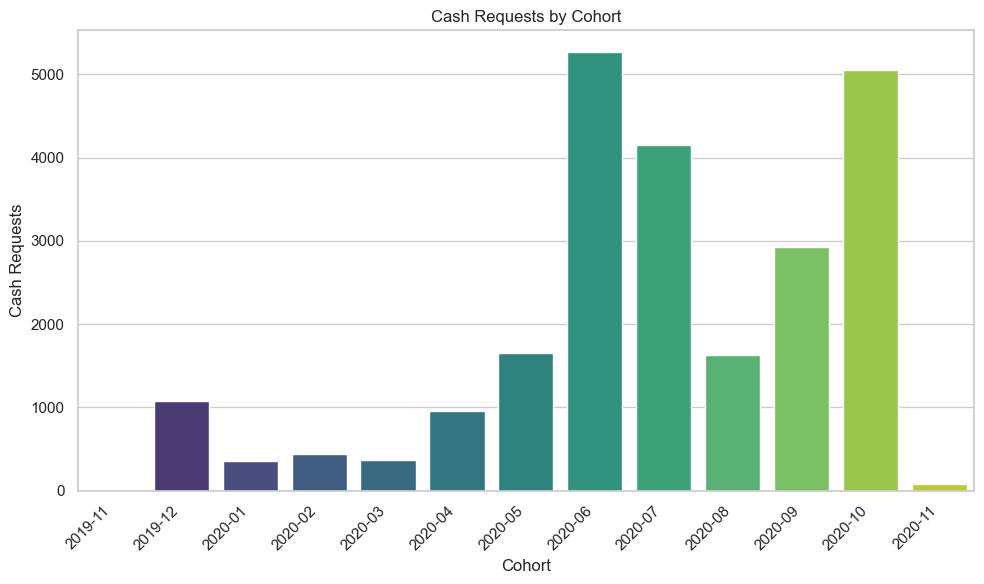

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# cash_request_by_cohorts = cashrequestdf.groupby("cohort").agg({"cash_request_id": "count"}).reset_index()
# sns.countplot(cash_request_by_cohorts["cohort"], cash_request_by_cohorts["cash_request_id"])

cashrequestdf = cashrequestdf.sort_values('cohort') # ordered by cohort for the chart

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=cashrequestdf, x='cohort', palette='viridis')  # <- Notice y='Country' instead of x
plt.title('Cash Requests by Cohort')
plt.xlabel('Cohort')
plt.ylabel('Cash Requests')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

In [71]:
# 3. unir los dataframes  (incident rates esta en la tabla de fees)

fees_with_user_id_and_cohort = pd.merge(left=feesdf, right=cashrequestdf, left_on="cash_request_id", right_on="cash_request_id", how="left")
print(feesdf.shape[0])
print(fees_with_user_id_and_cohort.shape[0]) # same as above
# TODO can do second metric here: 2. **Incident Rate:**
# TODO can do third metric here: 3. **Revenue Generated by the Cohort:**


21061
21061


In [72]:
# filtered only incidents
fees_with_user_id_and_cohort = fees_with_user_id_and_cohort.sort_values('cohort') # ordered by cohort for the chart
incident_feed = fees_with_user_id_and_cohort[fees_with_user_id_and_cohort["type"] == "incident"]

/var/folders/l6/tml7nl0s2dz6x09lhsl8hj840000gn/T/ipykernel_28789/70515042.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=incident_feed, x='cohort', palette='viridis')  # <- Notice y='Country' instead of x


AttributeError: 'function' object has no attribute 'plot'

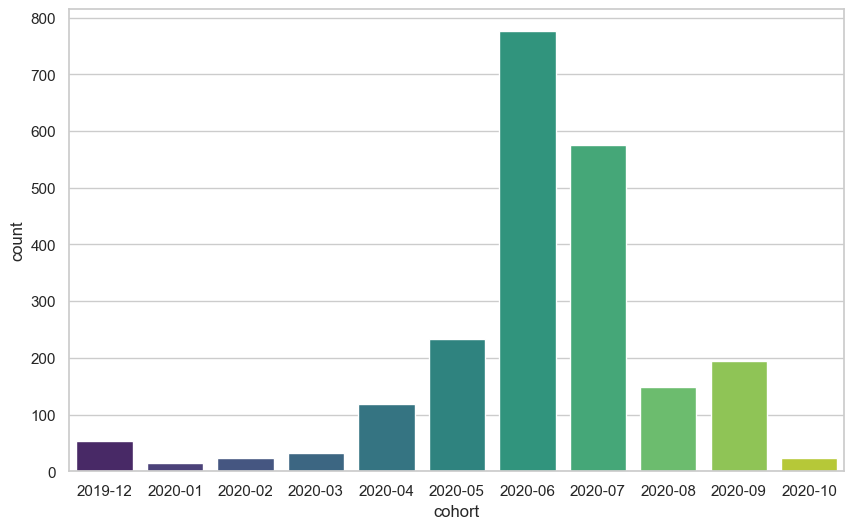

In [73]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=incident_feed, x='cohort', palette='viridis')  # <- Notice y='Country' instead of x
incident_feed.pivot.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Fee Incidents by Cohort')
plt.xlabel('Cohort')
plt.ylabel('Fee Incidents')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

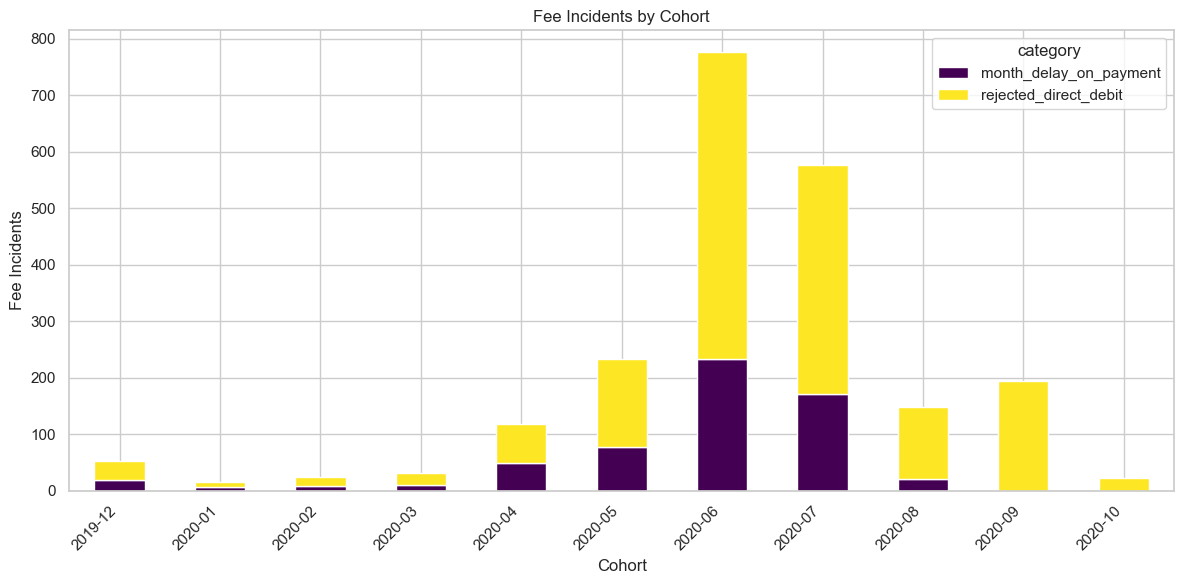

In [ ]:
pivot = incident_feed.pivot_table(
    index='cohort', 
    columns='category', 
    values='fee_id', 
    aggfunc='count'
).fillna(0)

pivot.plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    figsize=(12, 6)
)
plt.title("Fee Incidents by Cohort")
plt.xlabel("Cohort")
plt.ylabel("Fee Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#! por que hay tan pocos incidentes en 2020-10 cuando hay muchos cash requests

/var/folders/l6/tml7nl0s2dz6x09lhsl8hj840000gn/T/ipykernel_28789/529567035.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fee_total_amount_by_cohort, x='cohort', y="total_amount", palette='viridis')  # <- Notice y='Country' instead of x


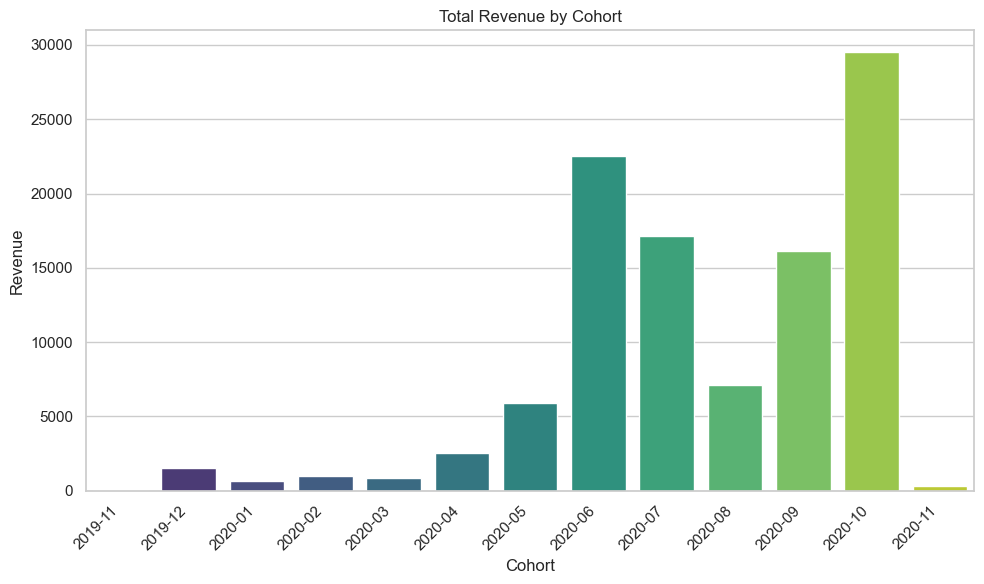

In [ ]:
# 3. **Revenue Generated by the Cohort:**

# 1. Accrual Accounting (most common for businesses)
# 📌 Revenue is recognized when the invoice is created (earned), not when paid.
# Example: If you issue an invoice on March 1 for services delivered, it's recorded as March revenue, even if the client pays in April.
# This matches revenue to when it was actually earned, not when cash arrives.
# ✅ Invoice creation = revenue recognition

#! cuales son los 4 que no tienen cohort
# fees_with_user_id_and_cohort[fees_with_user_id_and_cohort["cohort"].isnull()]

fee_total_amount_by_cohort = fees_with_user_id_and_cohort.groupby("cohort").agg({"total_amount": "sum"}).reset_index()
# print(fee_total_amount_by_cohort)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=fee_total_amount_by_cohort, x='cohort', y="total_amount", palette='viridis')  # <- Notice y='Country' instead of x
# incident_feed.pivot.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Total Revenue by Cohort')
plt.xlabel('Cohort')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

#! en 2020-10 hay alto revenue porque hay pocas incidencias


In [ ]:
# hacer correlacion entre incidents y revenue. Deberia dar hacia -1.
# Entre mayor cash request, no necesariamente tenemos más revenue, hay que considerar incidentes.

In [ ]:
# buscar usuarios que generan más revenue o incidents